<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/Praktikum_DL_2_Regresi_Linier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Pembelajaran Mendalam 2
## Regresi Linear
> Aditya Firman Ihsan



Pada praktikum kali ini, kita akan membangun model regresi linear dengan konsep perseptron dengan menggunakan library dasar Python. Model perseptron pada dasarnya hanya sebuah model optimisasi yang secara iteratif melakukan pembaharuan pada setiap parameternya dengan *gradient descent*.

### 1. Persiapan

#### 1.1. Import library

Seperti biasa, kita impor dulu semua yang dibutuhkan:
- [numpy](www.numpy.org): Numerical python, untuk hitung-hitung
- [matplotlib](http://matplotlib.org): MATLAB-nya python, untuk plotting. Yang kita butuhkan hanya `pyplot`
- [pandas](https://pandas.pydata.org/): Python Data Analysis, untuk mengolah data.

In [ ]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

#### 1.2. Menyiapkan dataset 

Kita akan gunakan [dataset Auto-MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) yang bisa diperoleh dari **UCI Machine Learning Repository**. File yang tersedia berformat `.data` namun bisa dibaca sebagai file csv, maka kita gunakan `pandas` untuk membacanya. 

Lebih lanjut baca https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Kita tidak akan melihat semua variabel bebasnya (atau disebut juga sebagai fitur). Kita ambil 2 data, yakni data daya dengan data MPG. Yang satu akan berperan sebagai variabel target (yang akan diprediksi)

In [ ]:
features = ['Horsepower', 'MPG']
dataset_train = raw_dataset[features]
dataset_train.describe()

,Horsepower,MPG
count,392.000000,398.000000
mean,104.469388,23.514573
std,38.491160,7.815984
min,46.000000,9.000000
25%,75.000000,17.500000
50%,93.500000,23.000000
75%,126.000000,29.000000
max,230.000000,46.600000


Data yang tersedia memiliki skala yang cukup berbeda, meskipun tidak jauh. Untuk mencegah bias, maka kita akan normalisasi data tersebut.

In [ ]:
def normalize(ds):
  for feature in features:
    mean = ds[feature].mean()
    std = ds[feature].std()

    # mengisi data kosong dengan rata-rata dari data
    ds[feature].fillna(mean, inplace=True)

    # normalisasi data sehingga memiliki rata-rata di 0 dan variansi 1
    ds[feature] = (ds[feature] - mean) / (std - 0.00001)

normalize(dataset_train)

# lihat sekilas hasilnya
dataset_train.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Horsepower,MPG
count,3.980000e+02,3.980000e+02
mean,2.622135e-17,-8.728361e-16
std,9.924148e-01,1.000001e+00
min,-1.519035e+00,-1.857039e+00
25%,-7.396346e-01,-7.695231e-01
50%,-2.460147e-01,-6.583605e-02
75%,5.333853e-01,7.018226e-01
max,3.261285e+00,2.953621e+00


In [ ]:
dataset_train.describe()

,Horsepower,MPG
count,3.980000e+02,3.980000e+02
mean,2.622135e-17,-8.728361e-16
std,9.924148e-01,1.000001e+00
min,-1.519035e+00,-1.857039e+00
25%,-7.396346e-01,-7.695231e-01
50%,-2.460147e-01,-6.583605e-02
75%,5.333853e-01,7.018226e-01
max,3.261285e+00,2.953621e+00


Terakhir, kita pisahkan antara fitur dengan target sebagai X dan y

In [ ]:
target_feature = 'MPG'

def split(ds):
  data = ds.copy()
  y = data.pop(target_feature).to_numpy()
  y = np.expand_dims(y, 1)
  X = data.to_numpy()
  return X, y

X_train, y_train = split(dataset_train)

In [ ]:
X_train.shape, y_train.shape

((398, 1), (398, 1))

### 2. Bangun Model

> Catatan: kita akan bangun di sini versi fungsional terlebih dahulu. Agar semakin kerasa manfaat penggunaan OOP kelak

#### 2.1. Inisialisasi parameter

Kita buat fungsi untuk inisiaisasi parameter $W$ dan $b$. Ada dua cara untuk inisialisasi, yakni dengan nol atau dengan acak. Keduanya disediakan di sini, silakan untuk mencoba-coba untuk melihat perbedaannya. Dimensi $W$ akan bergantung pada dimensi dari $X$, yang dalam hal ini berarti banyaknya fitur yang terlibat.


In [ ]:
def initialize_with_zeros(num_features):
    w = np.zeros((num_features, 1))
    b = 0.
    return w, b

def initialize_random(num_features):
    np.random.seed(40)
    w = np.random.rand(num_features, 1)
    b = np.random.rand(1)
    return w, b    

#### 2.2. Propagasi

Selanjutnya, akan didefinisikan fungsi propagasi, baik maju ataupun mundur. Ingat bahwa untuk propagasi maju, kita berusaha menghitung cost atau error yang ingin kita minimalisasi 
$$ Z = X\cdot w + b$$

$$ C = \frac{1}{N}[(Y - Z)'\cdot (Y-Z)]$$
dan untuk propagasi mundur, kita berusaha menghitung gradien dari cost terhadap parameter-parameter yang ada sehingga bisa di-update,
$$ \frac{dC}{dZ}=-\frac{1}{N}2(Y-Z)$$

$$\frac{\partial C}{\partial w}=\frac{\partial Z}{\partial w}\frac{dC}{dZ} = -\frac{1}{N}(X'\cdot 2(Y-Z))$$

$$\frac{\partial C}{\partial b} =\frac{\partial Z}{\partial b}\frac{dC}{dZ}= -\frac{1}{N}\sum_{m=1}^N2(y_m-z_m)$$

Nilai $N$ di atas adalah banyaknya data yang terlibat. Pembagian dengan $N$ berarti kita ingin menghitung cost rata-rata per data

In [ ]:
def propagate(w, b, X, Y):
    N = X.shape[0]

    # Forward
    Z = np.dot(X, w) + b
    e = Y - Z
    C = np.dot(e.T, e) / N

    # Backward
    dz = - 2 * e / N
    dw = np.dot(X.T, dz)
    db = np.sum(dz)
    
    grads = {"dw": dw,
             "db": db}    
    return grads, C

#### 2.3. Optimisasi

Optimisasi di sini berarti kita ingin menghitung
$$\min_{w,b}C$$
atau nilai cost $C$ paling kecil yang bisa didapatkan untuk semua kemungkinan parameter $w$ dan $b$. 

Untuk melakukannya, kita selalu update $w$ dan $b$ secara iteratif dengan melihat gradient dari $C$ terhadap masing-masing. Dalam hal ini, kita ingin $w$ dan $b$ selalu bergerak ke arah gradientnya atau berarti ke arah $C$ terkecil (ingat kalkulus peubah banyak).

Dengan suatu koefisien $\alpha$, pada setiap iterasi kita melakukan
$$w = w - \alpha \frac{\partial C}{\partial w}$$

$$b = b - \alpha \frac{\partial C}{\partial b}$$

Nilai $\alpha$ akan menentukan sejauh apa $w$ dan $b$ memperbarui dirinya setiap iterasi, sehingga terkadang menentukan kecepatan iterasi mencapai titik minimum. Dengan itu, $\alpha$ juga disebut sebagai *learning rate*

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):    
    costs = []
    
    for i in range(num_iterations):
        gradients, cost = propagate(w, b, X, Y)
        
        w = w - learning_rate * gradients["dw"]
        b = b - learning_rate * gradients["db"]
        
        # catat nilai cost setiap iterasi ke-100
        if i % 100 == 0:
            costs.append(cost)        
            if print_cost:
              print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"w": w, "b": b}
    return parameters, gradients, costs

#### 2.3. Prediksi

Kita lengkapi juga suatu fungsi sederhana untuk menghitung kembali nilai target dengan parameter yang sudah dioptimisasi.

In [ ]:
def predict(w, b, X):
    return np.dot(X, w) + b

#### 2.4. Bungkus!

Kita bungkus semua fungsi di atas menjadi sebuah fungsi untuk membangun dan melatih model

In [ ]:
def train(X, Y, num_iterations = 2000, learning_rate = 0.5, print_cost = False):    
    w, b = initialize_with_zeros(X.shape[1])
    params, grads, costs = optimize(w, b, X, Y, 
                                    num_iterations, 
                                    learning_rate, 
                                    print_cost)
    Y_pred = predict(w, b, X)
    accuracy = np.mean(np.abs(Y_pred - Y)) * 100
    print("train accuracy: {} %".format(accuracy))
    
    return {
        "costs": costs,
        "prediction" : Y_pred, 
        "w" : params['w'], 
        "b" : params['b'],
    }
    

### 3. Eksekusi


#### 3.1. Latih Model

Sekarang, semua sudah disiapkan, tinggal menggunakannya.

In [ ]:
result = train(X_train, y_train, 10000, 0.0005, print_cost = True)
result2 = train(X_train, y_train, 200, 0.01, print_cost = True)

model1 = ()

Cost after iteration 0: 0.997490
Cost after iteration 100: 0.891550
Cost after iteration 200: 0.804517
Cost after iteration 300: 0.733016
Cost after iteration 400: 0.674275
Cost after iteration 500: 0.626017
Cost after iteration 600: 0.586372
Cost after iteration 700: 0.553801
Cost after iteration 800: 0.527044
Cost after iteration 900: 0.505062
Cost after iteration 1000: 0.487002
Cost after iteration 1100: 0.472166
Cost after iteration 1200: 0.459977
Cost after iteration 1300: 0.449964
Cost after iteration 1400: 0.441738
Cost after iteration 1500: 0.434979
Cost after iteration 1600: 0.429427
Cost after iteration 1700: 0.424866
Cost after iteration 1800: 0.421119
Cost after iteration 1900: 0.418040
Cost after iteration 2000: 0.415511
Cost after iteration 2100: 0.413433
Cost after iteration 2200: 0.411726
Cost after iteration 2300: 0.410324
Cost after iteration 2400: 0.409172
Cost after iteration 2500: 0.408225
Cost after iteration 2600: 0.407448
Cost after iteration 2700: 0.406809
Cost

#### 3.2. Plot hasil

Kita lihat bahwa di akhir, akurasi model kita tidaklah banyak. Namun, sebelum kita ambil kesimpulan apapun, untuk melihat apakah regresi kita sudah berhasil, kita perlu plot untuk melihat kecocokannya dengan data.

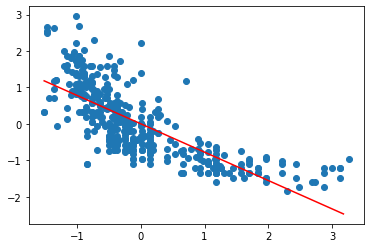

In [ ]:
x_res = np.arange(X_train.min(), X_train.max(), 0.1)
y_res = result['w'][0] * x_res + result['b']

plt.scatter(X_train, y_train)
plt.plot(x_res, y_res, color = "red")

Perhatikan bahwa ternyata memang data kita tidak lah berkorelasi secara linear, sehingga regresi linear kita tidak akan pernah bisa mencapai akurasi yang tinggi. Namun, dapat dilihat bahwa paling tidak ia ssudah mengikuti tren menurun yang terlihat pada data

3.3. Ekstensi

Melihat datanya, sepertinya memang regresi linear tidak cocok untuk memodelkan data tersebut. Kita coba ekstensi model menjadi polinom, paling tidak kuadratik, untuk memperbaiki model kita. 

Bagaimana caranya?
Kita buat seakan ada satu fitur tambahan yang sebenarnya hanya merupakan kuadrat dari fitur yang sudah ada. Ingat kembali bahwa kita miliki dataset seperti berikut

In [ ]:
dataset_train.head()

,Horsepower,MPG
0,0.663285,-0.705552
1,1.572585,-1.089381
2,1.182885,-0.705552
3,1.182885,-0.961438
4,0.923085,-0.833495


Kita tambahkan satu fitur yang merupakan kuadrat dari data Horsepower.

Prediksi fungsi linier
$$Z_1=w_1X+b_1$$
$$Y=w_2Z_1+b_2$$
$$Y=w_2(w_1X+b_1)+b_2$$
$$Y=(w_2w_1)X+(w_2b_1+b_2)$$
Fungsi aktivasi -> membuat jaringan nonlinier


In [ ]:
dataset_train["Horsepower2"] = dataset_train["Horsepower"]**2
dataset_train["Horsepower3"] = dataset_train["Horsepower"]**3
dataset_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Horsepower,MPG,Horsepower2,Horsepower3
0,0.663285,-0.705552,0.439947,0.291811
1,1.572585,-1.089381,2.473024,3.889041
2,1.182885,-0.705552,1.399217,1.655114
3,1.182885,-0.961438,1.399217,1.655114
4,0.923085,-0.833495,0.852086,0.786548


train accuracy: 83.59029034702581 %


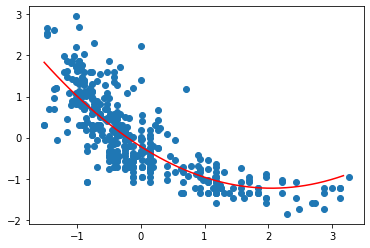

In [ ]:
X_train, y_train = split(dataset_train)
result = train(X_train, y_train, 10000, 0.0005, print_cost = False)
x_res = np.arange(X_train[:,0].min(), X_train[:,0].max(), 0.1)
y_res = (result['w'][0] * x_res) + (result['w'][1] * x_res**2) + result['b']
plt.scatter(X_train[:,0], y_train)
plt.plot(x_res, y_res, color = "red")

Perhatikan bahwa regresi kita jadi lebih baik bukan? Regresi polinom sampai orde-n pun memungkinkan dengan teknik yang serupa. Tapi melihat datanya, maka regresi kuadratik sudah dirasa cukup.

## Tugas

1. Menuju OOP

Perhatikan dengan seksama kode-kode di atas. Sangat tidak efektif kan? Banyak parameter fungsi yang dioper berkali-kali dan juga pemanfaatan variabel yang boros. Silakan ubah kode di atas menjadi berparadigma OOP!

2. Coba data lain

Sekarang, gunakan dataset berikut

In [ ]:
ds_train = pd.read_csv("/content/sample_data/california_housing_train.csv")
features = ['total_rooms', 'total_bedrooms', 'population', 'housing_median_age', 'median_house_value']
normalize(ds_train)
print("Data training:")
print(ds_train.describe())
N = len(ds_train)

x_features = ['total_rooms']
target = ['median_house_value']

X_train = np.array(ds_train[x_features]).reshape((N,1))
y_train = np.array(ds_train[target]).reshape((N,1))

Data training:
          longitude      latitude  ...  median_income  median_house_value
count  17000.000000  17000.000000  ...   17000.000000        1.700000e+04
mean    -119.562108     35.625225  ...       3.883578       -4.114160e-16
std        2.005166      2.137340  ...       1.908157        1.000000e+00
min     -124.350000     32.540000  ...       0.499900       -1.658007e+00
25%     -121.790000     33.930000  ...       2.566375       -7.578726e-01
50%     -118.490000     34.250000  ...       3.544600       -2.319369e-01
75%     -118.000000     37.720000  ...       4.767000        4.974756e-01
max     -114.310000     41.950000  ...      15.000100        2.523630e+00

[8 rows x 9 columns]


Berikan analisis terbaikmu menggunakan regresi polinom

(JAWABAN)

**Catatan untuk grader:**
Jawaban di bawah hanya untuk contoh saja, karena banyak variasi yang bisa dibuat dari tugas yang diberikan. 

1. Untuk tugas OOP: (1) Kelas bisa dipakai (diterapkan ke dataset dan  berhasil jalan dengan baik); (2) Strukturisasi kelasnya bagus (prinsip 1 metode/fungsi hanya menjalankan 1 tugas);

2. Untuk tugas regresi data lain: (1) Data preparationnya dilakukan dengan baik (dilakukan normalisasi dan mengubahnya menjadi array X dan Y); (2) Proses training baik, artinya cost berkurang iterasi dan dalam skala yang benar (sekitar 0-2); (3) Dilakukan plotting hasil dengan data; (4) Analisis terhadap hasil yang didapatkan secara jelas

In [ ]:
class LinearRegressor(object):
    def __init__(self, initializer = "random", cost_log = True):
        self.W = None
        self.b = None
        self.print_cost = cost_log
        self.initializer = initializer

    def initialize_with_zeros(self, num_features):
        self.w = np.zeros((num_features, 1))
        self.b = 0.

    def initialize_random(self, num_features):
        self.w = np.random.rand(num_features, 1)
        self.b = np.random.rand(1)

    def setup(self, X, Y, num_iterations = 2000, learning_rate = 0.5):
        if self.initializer == "zeros":
          self.initialize_with_zeros(X.shape[1])
        else:
          self.initialize_random(X.shape[1])
        self.costs = []
        self.X = X
        self.Y = Y
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate

    def propagate(self):
        N = self.X.shape[0]

        # Forward
        Z = np.dot(self.X, self.w) + self.b
        e = self.Y - Z
        self.costs.append(np.dot(e.T, e) / N)

        # Backward
        dz = - 2 * e / N
        dw = np.dot(self.X.T, dz)
        db = np.sum(dz)
        
        return dw, db

    def optimize(self):
        for i in range(self.num_iterations):
            dw, db = self.propagate()

            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
            
            if (i % 100 == 0) and (self.print_cost):
                  print ("Cost after iteration %i: %f" %(i, self.costs[i]))
        
    def predict(self):
        return np.dot(self.X, self.w) + self.b
              
    def train(self):
        self.optimize()
        Y_pred = self.predict()
        accuracy = np.mean(np.abs(Y_pred - self.Y)) * 100
        print("train accuracy: {} %".format(accuracy))

    def plot_result(self):
      x_res = np.arange(self.X[:,0].min(), self.X[:,0].max(), 0.1)
      y_res = (self.w[0] * x_res) + self.b
      plt.scatter(self.X[:,0], self.Y)
      plt.plot(x_res, y_res, color = "red")      

Cost after iteration 0: 1.429371
Cost after iteration 100: 1.348383
Cost after iteration 200: 1.282082
Cost after iteration 300: 1.227805
Cost after iteration 400: 1.183371
Cost after iteration 500: 1.146994
Cost after iteration 600: 1.117215
Cost after iteration 700: 1.092836
Cost after iteration 800: 1.072878
Cost after iteration 900: 1.056540
Cost after iteration 1000: 1.043164
Cost after iteration 1100: 1.032214
Cost after iteration 1200: 1.023250
Cost after iteration 1300: 1.015911
Cost after iteration 1400: 1.009904
Cost after iteration 1500: 1.004985
Cost after iteration 1600: 1.000959
Cost after iteration 1700: 0.997663
Cost after iteration 1800: 0.994965
Cost after iteration 1900: 0.992756
Cost after iteration 2000: 0.990947
Cost after iteration 2100: 0.989467
Cost after iteration 2200: 0.988255
Cost after iteration 2300: 0.987262
Cost after iteration 2400: 0.986450
Cost after iteration 2500: 0.985785
Cost after iteration 2600: 0.985241
Cost after iteration 2700: 0.984795
Cost

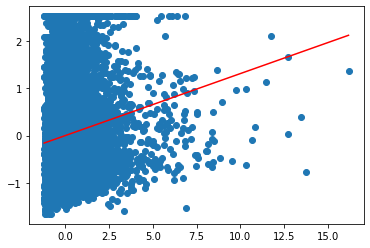

In [ ]:
model = LinearRegressor()
model.setup(X_train, y_train, 10000, 0.0005)
model.train()
model.plot_result()